<a href="https://colab.research.google.com/github/Juan-Draghi/relevamiento-boletin-oficial-caba-con-llm/blob/main/Busqueda_Boletin_Oficial_CABA_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

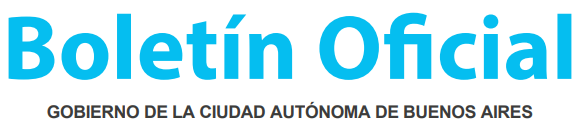

# 📄 Análisis automatizado del Boletín Oficial con filtrado semántico
Este notebook analiza el Boletín Oficial de la Ciudad de Buenos Aires para detectar automáticamente normativa relacionada con el ejercicio profesional de la arquitectura y el urbanismo, utilizando un enfoque mixto basado en búsqueda por palabras clave y evaluación semántica asistida por un modelo de lenguaje (LLM).

###Como construir expresiones regulares

| Tipo            | Plantilla general (personalizable)                                                   |
| --------------- | ------------------------------------------------------------------------------------ |
| **Disposición** | `r"[Dd]isposici[oó]n(?: [Nn]°?)? ?<NRO>(?:[-/]?GCABA)?[-/]?<REPARTICION>[-/]?<AÑO>"` |
| **Resolución**  | `r"[Rr]esoluci[oó]n(?: [Nn]°?)? ?<NRO>(?:[-/]?GCABA)?[-/]?<REPARTICION>[-/]?<AÑO>"`  |
| **Decreto**     | `r"[Dd]ecreto(?: [Nn]°?)? ?<NRO>/<AÑO>"`                                             |
| **Ley**         | `r"[Ll]ey(?: [Nn]°?)? ?<UNIDAD DE MIL>\.?<RESTO DEL NÚMERO>"` (con o sin punto en miles)                         |

🔁 Reemplazar los campos <NRO.>, <REPARTICIÓN> y <AÑO> por los valores que necesites.

In [ ]:
# 📦 Instalación de dependencias
!pip install pdfplumber openpyxl
!pip install tqdm
!pip install -q python-dotenv
!pip install -q -U google-generativeai
from google.colab import files
from google.colab import drive
from dotenv import load_dotenv
from tqdm.notebook import tqdm
from tenacity import retry, stop_after_attempt, wait_exponential
from google import genai
import pandas as pd
import pdfplumber
import logging
import re
import os
import glob
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

logging.getLogger("pdfminer").setLevel(logging.ERROR)


# 🧠 Lista de términos clave
keywords = [
    "Código Urbanístico",
    "Código de Edificación",
    "Código de Habilitaciones",
    "Reglamentos Técnicos",
    "Reglamento Técnico",
    "Autorización de actividades económicas",
    "Autorizaciones de actividades económicas",
    "Impacto ambiental",
    "Ley Marco de Regulación de Actividades Económicas de la Ciudad Autónoma de Buenos Aires",
    "Ley Tarifaria",
    "publicidad exterior",
    "Unidad Tarifaria",
    "Sistema de Autoprotección",
    "Sistemas de Autoprotección",
    "Catastro",
    "Derecho para el Desarrollo Urbano y el Hábitat Sustentable",
    "Código Fiscal",
    "Área Céntrica",
    "planos de mensura",
    "regularización de obras en contravención",
    r"[Dd]isposici[oó]n(?: [Nn]°?)? ?3\\.?500(?:[-/]?GCABA)?[-/]?DGOEP[-/]?16",
    r"[Dd]isposici[oó]n(?: [Nn]°?)? ?331(?:[-/]?GCABA)?[-/]?DGDCIV[-/]?25",
    r"[Dd]isposici[oó]n(?: [Nn]°?)? ?89(?:[-/]?GCABA)?[-/]?DGROC[-/]?24",
    r"[Dd]isposici[oó]n(?: [Nn]°?)? ?526(?:[-/]?GCABA)?[-/]?DGFYCO[-/]?24",
    r"[Rr]esoluci[oó]n(?: [Nn]°?)? ?275(?:[-/]?GCABA)?[-/]?APRA[-/]?23",
    r"[Rr]esoluci[oó]n(?: [Nn]°?)? ?188(?:[-/]?GCABA)?[-/]?SSGU[-/]?24",
    r"[Rr]esoluci[oó]n(?: [Nn]°?)? ?160(?:[-/]?GCABA)?[-/]?SSHA[-/]?24",
    r"[Rr]esoluci[oó]n(?: [Nn]°?)? ?96(?:[-/]?GCABA)?[-/]?AGC[-/]?25",
    r"[Rr]esoluci[oó]n(?: [Nn]°?)? ?345(?:[-/]?GCABA)?[-/]?AGC[-/]?21",
    r"[Rr]esoluci[oó]n(?: [Nn]°?)? ?103(?:[-/]?GCABA)?[-/]?APRA[-/]?25",
    r"[Rr]esoluci[oó]n(?: [Nn]°?)? ?1(?:[-/]?GCABA)?[-/]?MEPHUGC[-/]?25",
    r"[Dd]ecreto(?: [Nn]°?)? ?51/18", r"[Dd]ecreto(?: [Nn]°?)? ?86/19",
    r"[Dd]ecreto(?: [Nn]°?)? ?87/19", r"[Dd]ecreto(?: [Nn]°?)? ?99/19",
    r"[Dd]ecreto(?: [Nn]°?)? ?105/19", r"[Dd]ecreto(?: [Nn]°?)? ?475/20",
    r"[Dd]ecreto(?: [Nn]°?)? ?129/25", r"[Dd]ecreto(?: [Nn]°?)? ?116/25",
    r"[Dd]ecreto(?: [Nn]°?)? ?164/25", r"[Dd]ecreto(?: [Nn]°?)? ?189/25",
    r"[Ll]ey(?: [Nn]°?)? ?123", r"[Ll]ey(?: [Nn]°?)? ?2\\.?936",
    r"[Ll]ey(?: [Nn]°?)? ?5\\.?920", r"[Ll]ey(?: [Nn]°?)? ?6\\.?101",
    r"[Ll]ey(?: [Nn]°?)? ?6\\.?776", r"[Ll]ey(?: [Nn]°?)? ?6\\.?779",
    r"[Ll]ey(?: [Nn]°?)? ?6\\.?099", r"[Ll]ey(?: [Nn]°?)? ?6\\.?100",
    r"[Ll]ey(?: [Nn]°?)? ?6\\.?438", r"[Ll]ey(?: [Nn]°?)? ?6\\.?806",
    r"[Ll]ey(?: [Nn]°?)? ?6\\.?508", r"[Ll]ey(?: [Nn]°?)? ?6\\.?769"
  ]


# Lista de términos que indican pertinencia normativa (para pre-filtrado)
patrones_pertinencia = [
    r"\\bmodifica\\b", r"\\bmodifícase\\b", r"\\bmodificar\\b", r"\\bderoga\\b",
    r"\\bderogar\\b", r"\\bderógase\\b", r"\\baprueba\\b", r"\\baprobar\\b",
    r"\\bapruébese\\b", r"deja sin efecto", r"dejar sin efecto",
    r"déjase sin efecto", r"\\bsustituye\\b", r"\\bsustituir\\b",
    r"\\bsustitúyese\\b", r"\\bestablece\\b", r"\\bestablecer\\b",
    r"\\bestablécese\\b", r"\\bfija\\b", r"\\bfijar\\b", r"\\bfíjese\\b",
    r"\\bdetermina\\b", r"\\bdeterminase\\b", r"\\bdeterminar\\b"
]


# Función de pre-filtrado por terminos pertinentes
def contiene_verbos_pertinentes(texto):
    for patron in patrones_pertinencia:
        if re.search(patron, texto, re.IGNORECASE):
            return True
    return False

# Función de evaluación de pertinencia
@retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
def evaluar_pertinencia(texto_contexto, term):
    prompt = f"""
    Sos una persona experta en análisis jurídico y lectura crítica del Boletín Oficial.
    Tu tarea es analizar un fragmento de una norma y evaluar si la mención de "{term}" en el texto
    implica una acción normativa directa y explícita (como una modificación, derogación, aprobación, reglamentación, etc.).

    Texto del fragmento:
    \"\"\"{texto_contexto}\"\"\"

    Responde únicamente con "Pertinente" o "No pertinente".
    Si es una simple mención, cita o referencia a una norma sin modificarla, es "No pertinente".
    En caso de duda, responde "Pertinente".

    Ejemplos:
    - Texto: "Que el Código Fiscal vigente (texto ordenado 2025 Decreto N° 116/25)," → No pertinente
    - Texto: "Fijar en pesos 717,98 el valor de la Unidad Tarifaria." → Pertinente
    - Texto: "Deroga la Resolución N° 28-AGC/25 y aprueba el Procedimiento para la tramitación de Autorización de Actividades Económicas." → Pertinente
    - Texto: "Que por el Decreto N° 99/GCABA/2019 se reglamentó el Código Urbanístico aprobado por la Ley N° 6.099." → No pertinente
    """
    response = client.models.generate_content(
        model="gemini-2.5-flash", contents=prompt
    )
    return response.text.strip()


# --- Montaje de Drive y configuración ---
drive.mount('/content/drive')
carpeta_boletines = "/content/drive/MyDrive/Boletín Oficial/2025/06. Junio" # Cambiar la carpeta del mes cuando sea necesario
pdfs = glob.glob(os.path.join(carpeta_boletines, "*.pdf"))
if not pdfs:
    raise FileNotFoundError("No se encontraron archivos PDF en la carpeta indicada.")
pdf_mas_reciente = max(pdfs, key=os.path.getmtime)
print(f"Archivo seleccionado: {os.path.basename(pdf_mas_reciente)}")

ruta_env = "/content/drive/MyDrive/Colab Notebooks/.env"
load_dotenv(ruta_env)
api_key = os.getenv("GEMINI_API_KEY")
if not api_key:
    raise ValueError("La clave de API no se encontró. Verificá el archivo .env en Drive.")
client = genai.Client(api_key=api_key)


# --- Búsqueda inicial de términos ---
resultados = []
with pdfplumber.open(pdf_mas_reciente) as pdf:
    for i, page in enumerate(tqdm(pdf.pages, desc="Procesando páginas")):
        text = page.extract_text()
        if text:
            for term in keywords:
                matches = list(re.finditer(term, text, re.IGNORECASE))
                for m in matches:
                    start = max(m.start() - 300, 0)
                    end = m.end() + 300
                    context = text[start:end].replace('\\n', ' ')
                    resultados.append({
                        "Página": i + 1,
                        "Término": term,
                        "Contexto": context
                    })

if len(resultados) == 0:
    print("No se encontraron coincidencias iniciales.")
else:
    df_resultados = pd.DataFrame(resultados)
    # Lógica de filtrado y evaluación
    print(f"Se encontraron {len(df_resultados)} coincidencias iniciales.")

    # Paso de pre-filtrado con la función de verbos
    df_resultados['es_candidato'] = df_resultados['Contexto'].apply(contiene_verbos_pertinentes)
    df_para_evaluar = df_resultados[df_resultados['es_candidato'] == True]

    print(f"Pre-filtrado: {len(df_para_evaluar)} de {len(df_resultados)} coincidencias contienen verbos pertinentes y serán evaluadas por la IA.")

    resultados_filtrados = []

    # Lógica de procesamiento concurrente
    def procesar_fila(fila):
        decision = evaluar_pertinencia(fila["Contexto"], fila["Término"])
        if decision.lower().startswith("pertinente"):
            return {
                "Página": fila["Página"],
                "Término": fila["Término"],
                "Contexto": fila["Contexto"]
            }
        return None

    with ThreadPoolExecutor(max_workers=10) as executor:
        # Solo se envían a evaluar las filas pre-filtradas
        futuros = {executor.submit(procesar_fila, fila): fila for _, fila in df_para_evaluar.iterrows()}

        for futuro in tqdm(as_completed(futuros), total=len(df_para_evaluar), desc="Filtrando con Gemini"):
            resultado = futuro.result()
            if resultado:
                resultados_filtrados.append(resultado)

    print(f"Análisis finalizado. Se consideraron pertinentes {len(resultados_filtrados)} fragmentos.")

    # Guardar resultados en un único archivo Excel con dos hojas
    nombre_base_pdf = os.path.basename(pdf_mas_reciente).replace('.pdf', '')
    nombre_salida_unificado = f"Resultados_BOCABA_{nombre_base_pdf}.xlsx"

    with pd.ExcelWriter(nombre_salida_unificado) as writer:
        # Hoja con todos los hallazgos iniciales
        df_resultados.drop(columns=['es_candidato']).to_excel(writer, sheet_name='Todos los hallazgos', index=False)

        # Hoja con los resultados pertinentes finales
        if resultados_filtrados:
            df_filtrado = pd.DataFrame(resultados_filtrados)
            df_filtrado.drop_duplicates(subset=['Página', 'Término']).to_excel(writer, sheet_name='Hallazgos pertinentes', index=False)
        else:
            # Crea la hoja vacía si no hay nada pertinente
            pd.DataFrame().to_excel(writer, sheet_name='Hallazgos pertinentes', index=False)

    print(f"Archivo unificado generado: {nombre_salida_unificado}")
    files.download(nombre_salida_unificado)